Bologna Mathematics and Machine Learning for Image Analysis

Graded Assessment

Notebook authors: U. Kamilov, E. Chandler

Computational Imaging Group (CIG), WashU

# Complete this notebook
Similar to the lab, there will be parts that say `NotImplemented`. Make sure to complete these parts. Additionally, there are two questions at the end to which you should give a brief response.

# Set Up Environment
First, make a copy of this notebook to your drive by to File -> Save a copy in  drive.

Connect to a T4 GPU by clicking the dropdown button in the top right, clicking "Change runtime type" and selecting "T4 GPU". This will make everything run faster.

In [1]:
# Download pretrained weights (from DPIR paper)
!curl -L https://huggingface.co/deepinv/drunet/resolve/main/drunet_color.pth?download=true --output /content/drunet_color.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1135  100  1135    0     0   7183      0 --:--:-- --:--:-- --:--:--  7183
  0  124M    0 15901    0     0  43804      0  0:49:40 --:--:--  0:49:40 43804
curl: (23) Failed writing body (0 != 15901)


In [2]:
%pip install deepinv

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import numpy as np
import cv2
import deepinv as dinv
import matplotlib.pyplot as plt
from deepinv.utils.demo import load_degradation, load_url_image, get_image_url
from deepinv.utils.plotting import plot
from pathlib import Path
from torchvision import transforms
from deepinv.datasets import generate_dataset
from torch.utils.data import DataLoader
import os
from tqdm import tqdm

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


Selected GPU 0 with 32507 MB free memory 


# Get ground truth image

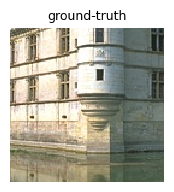

In [5]:
img_size = 128

url = get_image_url("CBSD_0010.png")
x_true = load_url_image(url=url, img_size=img_size, device=device)

x = x_true.clone()

plot(
    x_true,
    titles="ground-truth",
)

# Forward Model
Complete this cell to generate the measurement using deepinv. We are going to be using downsampling physics model from deepinv https://deepinv.github.io/deepinv/stubs/deepinv.physics.Downsampling.html#deepinv.physics.Downsampling

In [6]:
psnr = dinv.loss.PSNR(max_pixel=1.0) # for calculating PSNR

meas_sigma = 0.01 # measurement noise level

# Set up bluring operator.
kernel_torch = dinv.physics.blur.gaussian_blur(
    sigma=(1,1)
).to(device)

# Set up the downsampling operator with the blur kernel set as the filter,
# meas_sigma as the Gaussian noise sigma for noise_model, and (downsampling) factor equal to 2
# See https://deepinv.github.io/deepinv/stubs/deepinv.physics.Downsampling.html#deepinv.physics.Downsampling
physics = dinv.physics.Downsampling(
    factor=2,
    noise_model=dinv.physics.NoiseModel.Gaussian(sigma=meas_sigma),
    kernel=kernel_torch
)

# Acquire the measurement using physics
meas = physics(x_true)

# Use the adjoing of A for an initial "guess" of x.
adjoint_meas = physics.adjoint(meas)

# Use the adjoint of the measurement to compute the PSNR
adjoint_psnr = psnr( x_true.cpu(), adjoint_meas.cpu() ).item()

print(f"adjoint meas PSNR: {adjoint_psnr:0.2f}")

plot(
    [  x_true, meas, adjoint_meas ],
    titles=["ground-truth", "measurement", "A^T measurement"]
)


AttributeError: module 'deepinv.physics' has no attribute 'NoiseModel'

# Set Up PnP-HQS Algorithm
We will be using a half quadratic splitting (HQS) variant of PnP to solve the inverse problem.
Similar to PnP-ADMM, that we saw in the lab, PnP-HQS minimizes in an alternating fashion the following Lagrangian

$$\frac{1}{2} \| y - Ax \|_2^2 + \lambda h(z) + \frac{\mu}{2} \| x - z \|_2^2$$
As an exercise, develop the iterations of PnP-HQS by minimizing over x and z.

For this exercise, assume that $\text{prox}_{\gamma h}(x) = \cal{D}_{\gamma}(x)$; that is, $\gamma$ is the noise level to feed to the denoiser.
(Note that really it should be slightly different, but for simplicity this is okay. If you want to use PnP-HQS outside of this notebook, follow DPIR).

Now that you have developed the iterations, complete the pnp_hqs function to implement it.

In [ ]:
# mu schedule for PnP-HQS (Do not change this)
def get_mus(lam, num_iter, anneal=True):
  if anneal:
    mu_min = lam / (49. / 255.)
    mu_max = lam / (meas_sigma)

    mus = np.logspace(np.log10( mu_min ), np.log10( mu_max ), num_iter, base=10)

  else:
    mus = np.array([ lam / (6. / 255.) for _ in range(num_iter) ])

  return mus

# PnP HQS algorithm
def pnp_hqs(
            x_true,
            y,
            data_fidelity,
            network,
            num_iter,
            lam,
            mus
):
  '''
  x_true: ground truth image
  y: measurement
  data_fidelity: data fidelity term for reconstruction (we'll be using 0.5 || y - Ax ||)
  network: DNN used as image prior
  num_iter: number of PnP iterations to run
  lam: see above equation
  mus: see above equation
  '''
  # Make sure network in eval mode
  network.eval()

  # Initialize Variables
  x = NotImplemented # A.Ty
  z = NotImplemented # A.Ty

  # Track the data fidelity and psnrs of each iteration
  losses = [ data_fidelity(z,y, physics).item() ] # The data fidelity losses
  psnrs = [ psnr( x_true.cpu(), x.cpu() ).item() ]

  with torch.no_grad():
    for k in tqdm(range(num_iter)):
      z_prev = z
      mu = mus[k]

      # HQS updates

      # 1. Data fidelity proximal step
      # deepinv has this automatically implemented. Just fill out the parameters.
      x = NotImplemented

      # 2. Prior Step (through denoiser)
      noise_level = NotImplemented
      z = network( x, noise_level )

      # Track the data fidelity and psnrs of each iteration (see how it was computed above)
      losses.append( NotImplemented )
      psnrs.append( NotImplemented )

    # Return the last output from the denoiser
    recon = z

    return {"reconstruction": recon, "data_fidelities": losses, "psnrs": psnrs}


# Acquire Reconstructions
In lecture, it was mentioned that starting with a high noise level and then decreasing can help performance of PnP-HQS. We will now see this. The function `get_mus` will return mus that correspond to a decreasing noise level when `anneal=True` and will return a constant mu when `anneal=False`. We have already implemented this for you.

In [ ]:
denoiser = dinv.models.DRUNet(pretrained="/content/drunet_color.pth", device=device)
data_fidelity = dinv.optim.data_fidelity.L2()

# PnP-HQS Parameters. Do not change this when turning in.
lam = .23
num_iter = 24

mus = get_mus(lam, num_iter, anneal=False)
constant_result = NotImplemented

mus = get_mus(lam, num_iter, anneal=True)
annealed_result = NotImplemented



# Comparison
In the following cell, compare the reconstructed PSNRs and images.

In [ ]:
NotImplemented

# Give a brief response to the following
1. Why does reducing the noise level during the PnP iterations help?
2. Is PnP-HQS a fixed point algorithm when a constant mu is used? What about when a increasing mu is used? Why?